In [29]:
%matplotlib inline

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import tensorflow as tf
import math
tf.set_random_seed(42)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

import keras.backend.tensorflow_backend as K
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Lambda, BatchNormalization, Activation, UpSampling2D,  MaxPool2D
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam, RMSprop
from keras.initializers import RandomNormal
from keras import regularizers
from keras.datasets import mnist
import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt

import time
import pickle
import sys
import os

In [30]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# x_train = x_train[(y_train == 1) | (y_train == 0)]
x_train = (x_train - 127.5) / 127.5
x_test = (x_test - 127.5) / 127.5

# more data!
x_train = np.concatenate((x_train, x_test))
y_train = np.concatenate((y_train, y_test))



In [31]:
noise_dim = 100
input_shape = (28,28,1)
batch_size = 128
        
# dump_dir = "test_out"
# nepochs = 1000
# nepochs_to_dump_images = 50
# nepochs_to_dump_history = 100

dump_dir = "out_v4"
nepochs = 100000
nepochs_to_dump_images = 250
nepochs_to_dump_history = 5000

optimizer_d = RMSprop(lr=0.0001)
optimizer_g = RMSprop(lr=0.0001)
clip_amount = 0.1

In [32]:
def show_imgs(imgs):
    nrows = int(np.sqrt(imgs.shape[0]))
    ncols = imgs.shape[0]//nrows
    fig, axs = plt.subplots(nrows,ncols)
    fig.subplots_adjust(wspace=-0.70,hspace=0.1)
    for i,img in enumerate(imgs):
        if i>=nrows*ncols: break
        idx = i//ncols,i%ncols
        axs[idx].matshow(img)
        axs[idx].get_xaxis().set_visible(False)
        axs[idx].get_yaxis().set_visible(False)

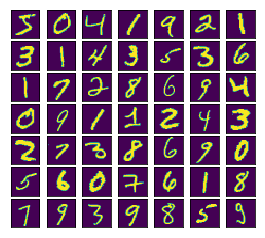

In [33]:
show_imgs(x_train[:50])

In [34]:
def build_discriminator():

    weight_init = RandomNormal(mean=0., stddev=0.02)

    input_image = Input(shape=(28, 28, 1), name='input_image')

    x = Conv2D(32, (3, 3),padding='same',kernel_initializer=weight_init)(input_image)
    x = LeakyReLU()(x)
    x = MaxPool2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (3, 3),padding='same',kernel_initializer=weight_init)(x)
    x = MaxPool2D(pool_size=1)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, (3, 3),padding='same',kernel_initializer=weight_init)(x)
    x = MaxPool2D(pool_size=2)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    x = Conv2D(256, (3, 3),padding='same',kernel_initializer=weight_init)(x)
    x = MaxPool2D(pool_size=1)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    features = Flatten()(x)

    output = Dense(1, activation='linear')(features)

    return Model(input_image, output)

In [35]:
def build_generator():

    weight_init = RandomNormal(mean=0., stddev=0.02)
    
    model = Sequential()

    model.add(Dense(1024,input_shape=(noise_dim,)))
    model.add(LeakyReLU())
    model.add(Dense(128 * 7 * 7))
    model.add(LeakyReLU())
    model.add(Reshape((7, 7, 128)))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2D(256, (5, 5), padding='same', kernel_initializer=weight_init))
    model.add(LeakyReLU())
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2D(128, (5, 5), padding='same', kernel_initializer=weight_init))
    model.add(LeakyReLU())
    model.add(Conv2D(1, (2, 2),padding='same',activation='tanh',kernel_initializer=weight_init))

    noise = Input(shape=(noise_dim,))
    img = model(noise)
    return Model(noise,img)


In [36]:
def wgan_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

def clip_d_weights(discriminator):
    weights = [np.clip(w, -clip_amount,clip_amount) for w in discriminator.get_weights()]
    discriminator.set_weights(weights)

In [ ]:

discriminator = build_discriminator()
discriminator.compile(loss=wgan_loss, optimizer=optimizer_d, metrics=['accuracy'])

generator = build_generator()
generator.compile(loss=wgan_loss, optimizer=optimizer_g)

z = Input(shape=(noise_dim,))
img = generator(z)

discriminator.trainable = False

valid = discriminator(img)
combined = Model(z, valid)
combined.compile(loss=wgan_loss, optimizer=optimizer_g)

discriminator.summary()
combined.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 64)        0         
__________

In [ ]:
os.system("mkdir -p {}/images/".format(dump_dir))
os.system("mkdir -p {}/history/".format(dump_dir))
half_batch = batch_size // 2
history = {"d_loss":[],"g_loss":[],"epoch":[]}
for iepoch in range(nepochs+1):
    
    if iepoch % 1000 < 10:
        ncritic = 50
    else:
        ncritic = 5
        
    for icritic in range(ncritic):

        # Select a random half batch of images and make some noise as input
        idx = np.random.randint(0, x_train.shape[0], half_batch)
        imgs = x_train[idx]
        imgs = np.reshape(imgs,list(imgs.shape)+[1])
        
        noise_half = np.random.normal(0, 1, (half_batch, noise_dim))

        # Generate a half batch of new images
        gen_imgs = generator.predict(noise_half)
        ones = np.ones((half_batch, 1))
        d_loss_real = discriminator.train_on_batch(imgs, -ones)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, ones)
        # The total loss is therefore the sum of the two (so lower is better)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Clip the discriminator weights
        clip_d_weights(discriminator)
        
    # The generator wants the discriminator to label the generated samples as valid
    valid_y = np.array([1] * batch_size)

    noise_full = np.random.normal(0, 1, (batch_size, noise_dim))

    # Train the generator
    g_loss = combined.train_on_batch(noise_full, -valid_y)
    
    if iepoch % nepochs_to_dump_images == 0:
        gen_imgs[:50].dump("{}/images/epoch_{}.npy".format(dump_dir,iepoch))

    # Plot the progress
    if iepoch % nepochs_to_dump_images == 0:
        print ("%d [D loss: %f] [G loss: %f]" % (iepoch, 1.-d_loss[0], 1.-g_loss))
        history["d_loss"].append(1.-d_loss[0])
        history["g_loss"].append(1.-g_loss)
        history["epoch"].append(iepoch)
        
    # Dump all previous losses every x epochs
    # Yes, this is inefficient since we're duplicating info
    # But I don't want to lose data if anything crashes/corrupts
    if iepoch % nepochs_to_dump_history == 0:
        np.c_[
            np.array(history["epoch"]),
            np.array(history["d_loss"]),
            np.array(history["g_loss"]),
        ].dump("{}/history/epoch_{}.npy".format(dump_dir,iepoch))
        


0 [D loss: 259.384033] [G loss: 20.376293]


In [28]:
history

{'d_loss': [-71780.25, -47391.75, -45891.40625, -26519.46875, -24534.875],
 'epoch': [0, 50, 100, 150, 200],
 'g_loss': [2463699.0, 1234932.0, 1006520.1875, 833772.9375, 682145.1875]}

In [ ]:
to_plot = np.reshape(gen_imgs,list(gen_imgs.shape)[:-1])
show_imgs(to_plot[:50])